In [ ]:
#Q3 base model
from comet_ml import Experiment
import os 


comet_experiment = Experiment(
    api_key=os.environ.get('COMET_API_KEY'),  # don’t hardcode!!
    project_name="milestone-project-2",
    workspace="anshitasaxena",
)

#set an experiment name with for basemodel
comet_experiment.set_name("basemodel")

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibrationDisplay
import joblib
import seaborn as sns
np.random.seed(42)

def plotting( y_test, y_pred_proba, graph_paras):
    '''This function visualizes the performance of learning models. Arguments: y_test: validation labels, 
    y_pred_proba: probability estimates for labels. Outputs: ROC curve, probability percentile, calibration curve'''
    # (a) ROC curve
    

    ns_probs = [0 for _ in range(len(y_test))]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    ns_auc = metrics.roc_auc_score(y_test, ns_probs)
    
    ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
    

    plt.plot(fpr, tpr, linestyle='-', color="darkorange",lw=2, label=f"{graph_paras['model']} AUC = %0.2f" % auc)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', color="red",lw=2, label="AUC = %0.2f" % ns_auc)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    # show the legend
    plt.legend()
    #save plot to cmet.ml
    comet_experiment.log_figure(figure_name= f"AUC ROC  curve {graph_paras['model']}", overwrite=False,                                         step=None)
    # show the plot
    plt.show()


    # Plotting Goal Rate versus Shot probability model percentile
    # Convert 2-D to 1-D series
    # Plotting Goal Rate versus Shot probability model percentile
    # Convert 2-D to 1-D series
    new_series = np.array(y_test)
    new_series = np.reshape(new_series, (new_series.shape[0]))

    # Scale true_probabilities (predict_proba() returns true and false both) on percentile
    true_prob = pd.DataFrame()
    true_prob['true_target'] = np.array(new_series)
    percentile = [[np.percentile(y_pred_proba, i), np.percentile(y_pred_proba, i+5)] 
                  for i in range(0,100,5)]
    total_goal = np.sum(new_series)
    # print(percentile)

    # Looping on probabilities to check their percentiles with their status as goal/shot
    goal_probability = []
    cum_prop = []
    # print(true_prob.shape)
    for i in range(0, len(percentile)):
        # Check the interval of probability in percentile and calculate the number of goals
        true_prob_percentile = true_prob[(y_pred_proba<=percentile[i][1]) & (y_pred_proba>percentile[i][0])]
        goals = true_prob_percentile.loc[true_prob_percentile['true_target']==1].shape[0]
        # Check the interval of probability in percentile and calculate the number of no goals (or shots)
        no_goals = true_prob_percentile.loc[true_prob_percentile['true_target']==0].shape[0]
        # If no goal, do nothing, calculate the formula if goal
        if goals == 0:
            goal_probability.append(0)
        else:
            goal_probability.append((goals*100)/(goals+no_goals))
    
    # Axis for percentile
    shot_prob_model_percentile = np.arange(0, 100, 5)

    # Plot of goal rate vs Shot probability percentile
    fig_goal_rate = plt.figure(figsize=(7, 5))
    sns.set()
    plt.plot(shot_prob_model_percentile, goal_probability, label=graph_paras['model'])
    plt.xlim(100, 0)
    plt.ylim(0, 100)
    plt.title("Goal Rate")
    plt.xlabel('Shot probability model percentile', fontsize=14)
    plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
    plt.ylabel('Goals / (Shots + Goals)', fontsize=14)
    y_axis = [0,10,20,30,40,50,60,70,80,90,100]
    y_values = ['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']
    plt.yticks(y_axis, y_values)
    plt.legend()
    
    comet_experiment.log_figure(figure_name= f"Goal versus Shot Probability Model Percentile {graph_paras['model']}",                                overwrite=False, step=None)
    plt.show()

    
    
    # (c) Cumulative 
    
            # Plot the cumulative proportion of goals
    # Convert 2-D to 1-D series
    new_series = np.array(y_test)
    new_series = np.reshape(new_series, (new_series.shape[0]))

    # Scale true_probabilities (predict_proba() returns true and false both) on percentile
    true_prob = pd.DataFrame()
    true_prob['true_target'] = np.array(new_series)
    percentile = [[np.percentile(y_pred_proba, i), np.percentile(y_pred_proba, i+1)] 
                  for i in range(0,100,1)]
    total_goal = np.sum(new_series)

    # Looping on probabilities to check their percentiles with their status as goal/shot
    cum_prop = []
    for i in range(0, len(percentile)-1):
        # We need previous and current goal lie in the percentile
        true_prob_percentile = true_prob[(y_pred_proba>=percentile[i][0])]
        goals = true_prob_percentile.loc[true_prob_percentile['true_target']==1].shape[0]
        # If no goal, do nothing, calculate the formula if goal
        cum_prop.append(goals*100/total_goal)
    cum_prop.append(0)

    # Axis for percentile
    shot_prob_model_percentile = np.arange(0, 100, 1)
   
    # Plot of cumulative frequency vs Shot probability percentile
    fig_cum_shot = plt.figure(figsize=(7, 5))
    sns.set()
    plt.plot(shot_prob_model_percentile, cum_prop, label=graph_paras['model'])
    plt.xlim(100, 0)
    plt.ylim(0, 100)
    plt.title("Cumulative % of goals")
    plt.xlabel('Shot probability model percentile', fontsize=14)
    plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
    plt.ylabel('Proportion', fontsize=14)
    y_axis = [0,10,20,30,40,50,60,70,80,90,100]
    y_values = ['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']
    plt.yticks(y_axis, y_values)
    plt.legend(loc='upper left')
    comet_experiment.log_figure(figure_name= f"Cumulative Proportion of Goals {graph_paras['model']}",                                                       overwrite=False,step=None)
    plt.show()

    # (d) Calibration curve
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
    plt.rcParams["figure.figsize"] = (8,5)
    disp = CalibrationDisplay(prob_true, prob_pred, y_pred_proba)
    disp.plot(label=f"{graph_paras['model']}" )
    plt.title("Calibration Curve/Reliability Diagram")

    comet_experiment.log_figure(figure_name= f"Caliberative Curve {graph_paras['model']}", overwrite=False, step=None)
    plt.show()



In [ ]:
## load data
print('Preparing data:')
df = pd.read_csv('df_feature_engineering.csv')
features = ['shot distance', 'shot angle']
X = df[features]
y = df['is goal']

## split data
X_train_f, X_test_f, y_train, y_test = train_test_split(X, y, test_size=0.25)
print("Traning size: %d" % (len(y_train)))
print("Validation size: %d" % (len(y_test)))


Preparing data:
Traning size: 230999
Validation size: 77000


In [ ]:
# QUESTION 3.1
### Distance model
print('Logistic Regression: Distance')
f = ['shot distance']
X_train = X_train_f[f]
X_test = X_test_f[f]


logreg_D = LogisticRegression(random_state=42)

# fit the model with data
logreg_D.fit(X_train, y_train)

y_pred = logreg_D.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("f1-score: %.2f%%" % (f1 * 100.0))
print("Confusion Matrix:")
print(confusion)

Logistic Regression: Distance
Accuracy: 90.53%
f1-score: 0.00%
Confusion Matrix:
[[69710     0]
 [ 7290     0]]


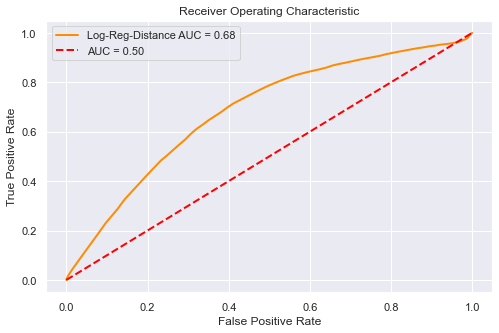

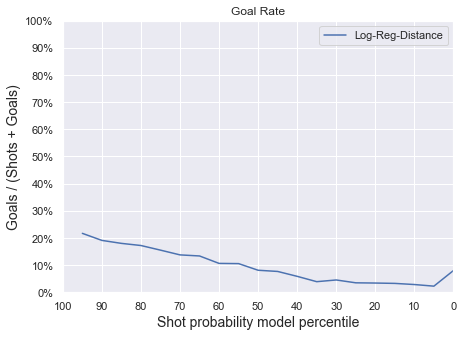

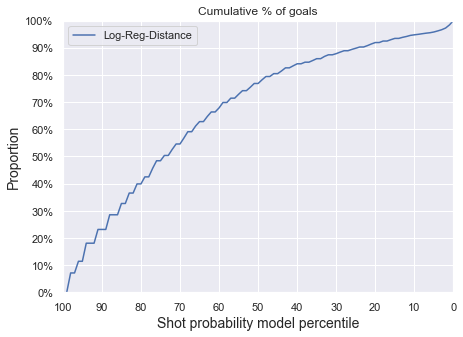

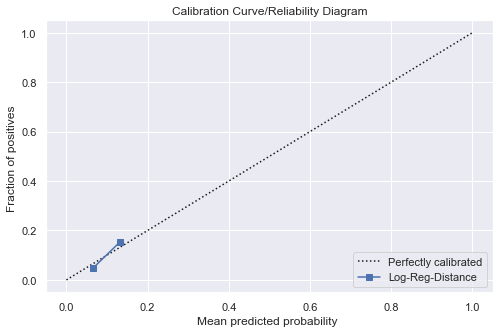

['basemodel_Log-Reg-Distance.joblib']

In [ ]:
# QUESTION 3.2
y_pred_proba = logreg_D.predict_proba(X_test)[::,1]
plotting(y_test, y_pred_proba, graph_paras={'model':'Log-Reg-Distance'})


#tracking and dumping the model
joblib.dump(logreg_D, 'basemodel_Log-Reg-Distance.joblib')

Logistic Regression: Angle
Accuracy: 90.53%
f1-score: 0.00%
Confusion Matrix:
[[69710     0]
 [ 7290     0]]


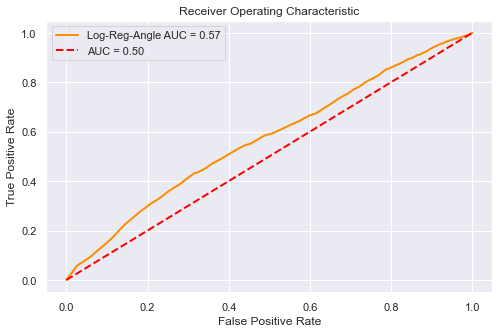

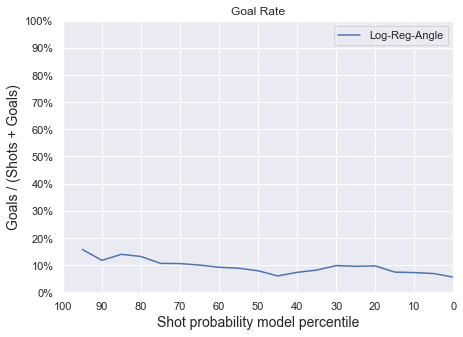

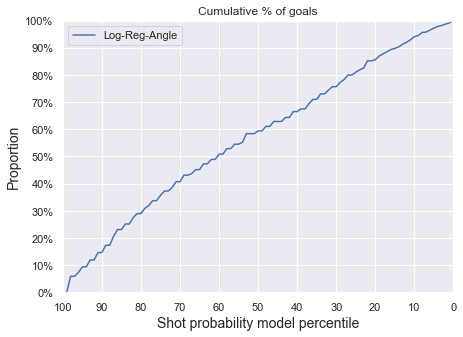

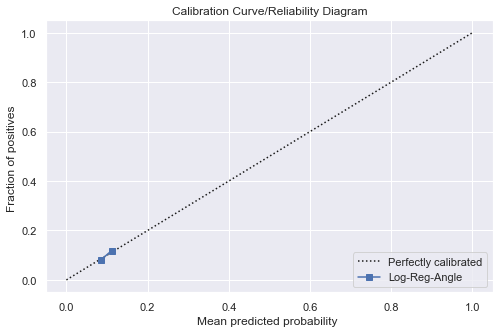

['basemodel_Log-Reg-Angel.joblib']

In [ ]:
# QUESTION 3.3
### Angle model
print('Logistic Regression: Angle')
f = ['shot angle']
X_train = X_train_f[f]
X_test = X_test_f[f]

logreg_A = LogisticRegression(random_state=42)
logreg_A.fit(X_train, y_train)


y_pred = logreg_A.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("f1-score: %.2f%%" % (f1 * 100.0))
print("Confusion Matrix:")
print(confusion)

y_pred_proba = logreg_A.predict_proba(X_test)[::,1]
plotting(y_test, y_pred_proba,graph_paras={'model':'Log-Reg-Angle'})

#tracking and dumping the model
joblib.dump(logreg_D, 'basemodel_Log-Reg-Angel.joblib')

Logistic Regression: Distance & Angle
Accuracy: 90.53%
f1-score: 0.00%
Confusion Matrix:
[[69710     0]
 [ 7290     0]]


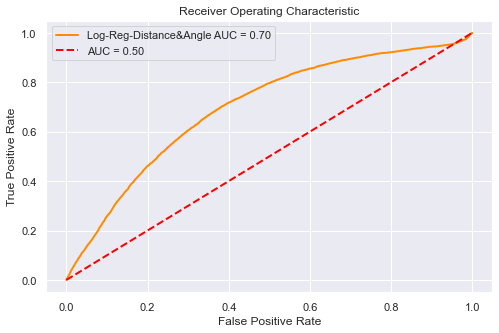

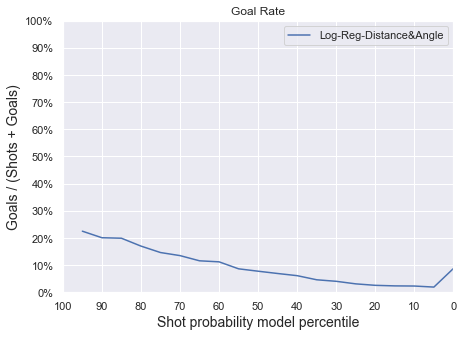

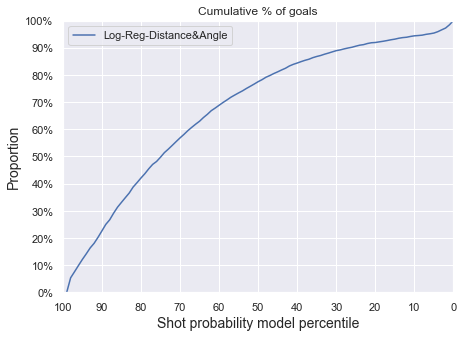

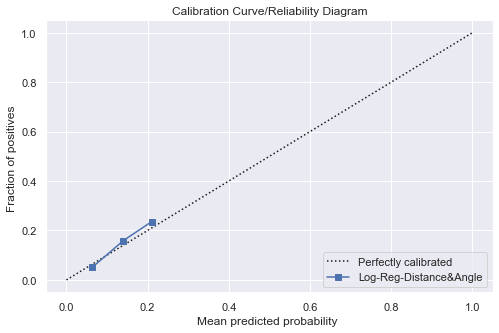

['basemodel_Log-Reg-Distance&Angle.joblib']

In [ ]:
### Distance and angle model
print('Logistic Regression: Distance & Angle')

f = ['shot angle', 'shot distance']
X_train = X_train_f[f]
X_test = X_test_f[f]


logreg_DA = LogisticRegression(random_state=42)

# fit the model with data
logreg_DA.fit(X_train, y_train)

y_pred = logreg_DA.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("f1-score: %.2f%%" % (f1 * 100.0))
print("Confusion Matrix:")
print(confusion)


y_pred_proba = logreg_DA.predict_proba(X_test)[::,1]
plotting(y_test, y_pred_proba,graph_paras={'model':'Log-Reg-Distance&Angle'})

#tracking and dumping the model
joblib.dump(logreg_D, 'basemodel_Log-Reg-Distance&Angle.joblib')

In [ ]:
### Uniform distribution
print('Predicting by uniform distribution')
y_pred_proba = np.random.uniform(low=0.0, high=1.0, size=len(y_test))
plotting(y_test, y_pred_proba,graph_paras={'model':'UniformDist'})